In [1]:
%matplotlib inline
from statistics import mode
import numpy as np
import sklearn 
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
import csv
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

/Users/anhuishi/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('hotel_bookings.csv')

df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
def with_hue(ax, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    for i in range(Number_of_categories):
        total = np.sum(a[::hue_categories])
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height()
            ax.annotate(percentage, (x, y), size = 12)

In [4]:
def barPerc(df,xVar,ax):
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable 
        ax: Axes object (for Seaborn Countplot/Bar plot or
                         pandas bar plot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom")

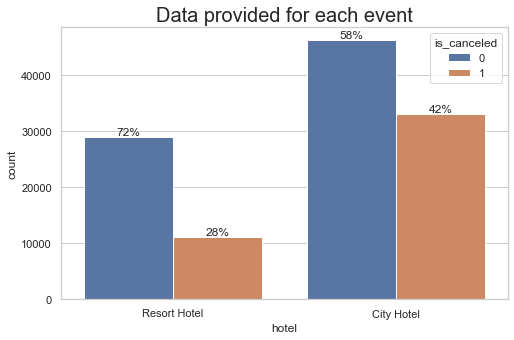

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
ax = sns.countplot(x="hotel", hue="is_canceled", data=df)
plt.title('Data provided for each event', fontsize=20)
barPerc(df, 'hotel',ax)
plt.show()

In [6]:
df.hotel

0         Resort Hotel
1         Resort Hotel
2         Resort Hotel
3         Resort Hotel
4         Resort Hotel
              ...     
119385      City Hotel
119386      City Hotel
119387      City Hotel
119388      City Hotel
119389      City Hotel
Name: hotel, Length: 119390, dtype: object

In [7]:
#class count
canceled_count_0, canceled_count_1 = df['is_canceled'].value_counts()

#separate class
canceled_0 = df[df['is_canceled']==0]
canceled_1 = df[df['is_canceled']==1]
print('is_canceled = 0:', canceled_0.shape)
print('is_canceled = 1:', canceled_1.shape)

is_canceled = 0: (75166, 32)
is_canceled = 1: (44224, 32)


The proportion of minority class is higher than 20%, but we will apply SMOTE method on the training set to check if the accuracy of prediction will be higher.

In [8]:
# Drop unecessary columns - data w/o dealing with imbalance problem
df = df.drop(['arrival_date_year','arrival_date_day_of_month','meal',
              'country','assigned_room_type','agent','company','reservation_status',
              'reservation_status_date',], axis = 1)

In [9]:
# Categorical variable for resort hotel
df['is_resort'] = df['hotel'].apply(lambda x: 1 if x == 'Resort Hotel' else 0)
df = df.drop('hotel', axis = 1)

In [10]:
# Categorical variable for deposit
df['is_deposit'] = df['deposit_type'].apply(lambda x: 0 if x == 'No Deposit' else 1)
df = df.drop('deposit_type', axis = 1)

In [11]:
# Categorical variable for customer type
df['is_contract'] = df['customer_type'].apply(lambda x: 1 if x == 'Contract' else 0)
df = df.drop('customer_type', axis = 1)

In [12]:
# Categorical variable for market segement and distribution channel
le = preprocessing.LabelEncoder()

# fit label encoder and return encoded integer labels for categorical string features
df['market_segment'] = le.fit_transform(df['market_segment'].values)
df['distribution_channel'] = le.fit_transform(df['distribution_channel'].values)
df['reserved_room_type'] = le.fit_transform(df['reserved_room_type'].values)
df['arrival_date_month'] = le.fit_transform(df['arrival_date_month'].values)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   lead_time                       119390 non-null  int64  
 2   arrival_date_month              119390 non-null  int64  
 3   arrival_date_week_number        119390 non-null  int64  
 4   stays_in_weekend_nights         119390 non-null  int64  
 5   stays_in_week_nights            119390 non-null  int64  
 6   adults                          119390 non-null  int64  
 7   children                        119386 non-null  float64
 8   babies                          119390 non-null  int64  
 9   market_segment                  119390 non-null  int64  
 10  distribution_channel            119390 non-null  int64  
 11  is_repeated_guest               119390 non-null  int64  
 12  previous_cancell

In [14]:
# Check if any column has null
for i in list(df.columns):
    if np.any(np.isnan(df[i])) == True:
        print(i)

children


In [15]:
# Fill 0 for null in children
df['children'].fillna(value = 0 , inplace=True)

In [16]:
#data without dealing with imbalance problem
x,y = df.drop (['is_canceled'],axis = 1 ), df['is_canceled']
train_x, test_x, train_y, test_y = train_test_split(x,y, train_size = 0.8, test_size = 0.2)

In [17]:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)


In [18]:
# CV for Random Forest
RF = RandomForestClassifier(max_depth = 18)
cv_RF_results = cross_val_score(RF, 
                                 x, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)

mean_score_RF= round(np.mean(cv_RF_results), 4)
mean_score_RF


0.8398

In [19]:
# CV RMSE
cv_RF_RMSE = -cross_val_score(RF, 
                                x, y, 
                                cv=split,
                                scoring="neg_mean_squared_error",
                                n_jobs=-1)

mean_cv_RF_RMSE = round(np.mean(cv_RF_RMSE), 4)
np.sqrt(mean_cv_RF_RMSE)

0.40024992192379

In [20]:
# RMSE of Random Forest
RF.fit(train_x, train_y)

# Use trained regression model to predict interest rates of training and test data
RF_train_pred = RF.predict(train_x)
RF_test_pred = RF.predict(test_x)
# Print RMSE 
RMSE_Train_RF = np.sqrt(mean_squared_error(train_y, RF_train_pred))
RMSE_Test_RF = np.sqrt(mean_squared_error(test_y, RF_test_pred))
print('RMSE on training data: ', RMSE_Train_RF )
print('RMSE on test data: ', RMSE_Test_RF )

RMSE on training data:  0.36111281134542816
RMSE on test data:  0.39834863075883603


In [21]:
# Recall score of Random Foreset
from sklearn.metrics import recall_score
RF_recall = recall_score(test_y, RF_test_pred)
RF_recall

0.6763257999552472

In [22]:
# CV for Logisticc Regression
LR = LogisticRegression(max_iter = 5000)
cv_LR_results = cross_val_score(LR, 
                                 x, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
mean_score_LR = round(np.mean(cv_LR_results), 4)
mean_score_LR

0.7984

In [23]:
# RMSE of LogisticRegression
LR.fit(train_x, train_y)

# Use trained regression model to predict interest rates of training and test data
LR_train_pred = LR.predict(train_x)
LR_test_pred = LR.predict(test_x)
# Print RMSE 
RMSE_Train_LR = np.sqrt(mean_squared_error(train_y, LR_train_pred))
RMSE_Test_LR = np.sqrt(mean_squared_error(test_y, LR_test_pred))
print('RMSE on training data: ', RMSE_Train_LR )
print('RMSE on test data: ', RMSE_Test_LR )

RMSE on training data:  0.44819112294532587
RMSE on test data:  0.45003280445524535


In [24]:
# CV for XGBClassifier
XGB = XGBClassifier(use_label_encoder = False, eval_metric='mlogloss')
cv_XGB_results = cross_val_score(XGB, 
                                 x, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)

mean_score_XGB = round(np.mean(cv_XGB_results), 4)
mean_score_XGB

0.8363

In [25]:
# RMSE of XGBClassifier
XGB.fit(train_x, train_y)

# Use trained regression model to predict interest rates of training and test data
XGB_train_pred = XGB.predict(train_x)
XGB_test_pred = XGB.predict(test_x)
# Print RMSE 
RMSE_Train_XGB = np.sqrt(mean_squared_error(train_y, XGB_train_pred))
RMSE_Test_XGB = np.sqrt(mean_squared_error(test_y, XGB_test_pred))
print('RMSE on training data: ', RMSE_Train_XGB )
print('RMSE on test data: ', RMSE_Test_XGB )

/Users/anhuishi/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE on training data:  0.3880167497332306
RMSE on test data:  0.405950793286655


In [26]:
# CV for Decision Tree Classifier
DT = DecisionTreeClassifier(max_depth = 18)
cv_DT_results = cross_val_score(DT, 
                                 x, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)

mean_score_DT = round(np.mean(cv_DT_results), 4)
mean_score_DT

0.8216

In [27]:
# RMSE of Decision Tree 
DT.fit(train_x, train_y)

# Use trained regression model to predict interest rates of training and test data
DT_train_pred = DT.predict(train_x)
DT_test_pred = DT.predict(test_x)
# Print RMSE 
RMSE_Train_DT = np.sqrt(mean_squared_error(train_y, DT_train_pred))
RMSE_Test_DT = np.sqrt(mean_squared_error(test_y, DT_test_pred))
print('RMSE on training data: ', RMSE_Train_DT )
print('RMSE on test data: ', RMSE_Test_DT )

RMSE on training data:  0.3525005502256311
RMSE on test data:  0.42342221528044294


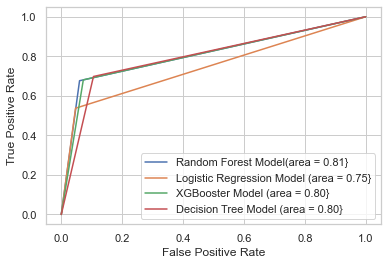

In [28]:
# ROC curve for the models

RFfpr, RFtpr, RFthresholds = roc_curve(test_y, RF.predict(test_x))
RFauc = roc_auc_score(test_y, RF.predict(test_x))

LRfpr, LRtpr, LRthresholds = roc_curve(test_y, LR.predict(test_x))
LRauc = roc_auc_score(test_y, LR.predict(test_x))

XGBfpr,XGBtpr,XGBthreshholds = roc_curve(test_y, XGB.predict(test_x))
XGBauc = roc_auc_score(test_y, XGB.predict(test_x))

DTfpr,DTtpr,DTthreshholds = roc_curve(test_y, DT.predict(test_x))
DTauc = roc_auc_score(test_y, DT.predict(test_x))

plt.plot(RFfpr, RFtpr, label='Random Forest Model(area = %0.2f}' %RFauc)
plt.plot(LRfpr, LRtpr, label='Logistic Regression Model (area = %0.2f}' %LRauc)
plt.plot(XGBfpr, XGBtpr, label='XGBooster Model (area = %0.2f}' %XGBauc)
plt.plot(DTfpr, DTtpr, label='Decision Tree Model (area = %0.2f}' %DTauc)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


### Select our best model

In [29]:
#comapring score and rmse for each model
models = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'XGBClassifier', 
              'Decision Tree'],
    
    'CV_accuracy_mean_score': [mean_score_RF, mean_score_LR, mean_score_XGB,mean_score_DT],
    'RMSE_Train': [RMSE_Train_RF, RMSE_Train_LR, RMSE_Train_XGB, RMSE_Train_DT],
    'RMSE_Test': [RMSE_Test_RF, RMSE_Test_LR, RMSE_Test_XGB, RMSE_Test_DT],
    'roc_auc_score': [RFauc, LRauc, XGBauc, DTauc]})

models = models.sort_values(["CV_accuracy_mean_score","RMSE_Test"], ascending = (False,True))
models

,Model,CV_accuracy_mean_score,RMSE_Train,RMSE_Test,roc_auc_score
0,Random Forest,0.8398,0.361113,0.398349,0.808176
2,XGBClassifier,0.8363,0.388017,0.405951,0.804167
3,Decision Tree,0.8216,0.352501,0.423422,0.796003
1,Logistic Regression,0.7984,0.448191,0.450033,0.745201


From the output, we can find that Random Forest is the best model because it has the highest in CV mean score and roc auc score and lowest in RMSE score. Next, we will apply feature importance analysis and smote train set on the random forest model and check if the performance can be better.

In [30]:
# Feature Importance
importances = RF.feature_importances_
std = np.std([RF.feature_importances_ for tree in RF.estimators_], axis=0)
forest_importances = pd.Series(importances, index= x.keys())

Text(0.5, 0, 'Random Forest Feature Importance')

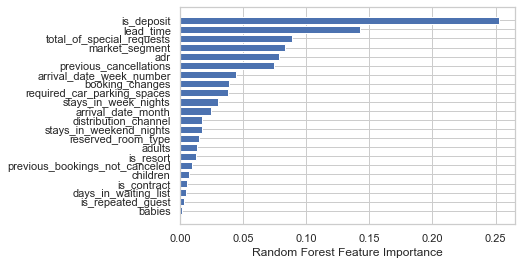

In [31]:
sorted_idx = RF.feature_importances_.argsort()
plt.barh(x.keys()[sorted_idx], RF.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Recursive Feature elimination:
Recursive feature elimination performs a greedy search to find the best performing feature subset. It iteratively creates models and determines the best or the worst performing feature at each iteration. It constructs the subsequent models with the left features until all the features are explored. It then ranks the features based on the order of their elimination. In the worst case, if a dataset contains N number of features RFE will do a greedy search for 2N combinations of features.

In [32]:
from sklearn.feature_selection import RFE

# Feature extraction 
model = RandomForestClassifier(max_depth = 18)
rfe = RFE(model, n_features_to_select=12) #select 12 variables
fit = rfe.fit(train_x, train_y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 12
Selected Features: [ True  True  True False  True False False False  True False False  True
 False  True  True False  True  True  True False  True False]
Feature Ranking: [ 1  1  1  2  1  4  7 11  1  3 10  1  6  1  1  9  1  1  1  5  1  8]


In [33]:
names=pd.DataFrame(train_x.columns)
rankings = pd.DataFrame(fit.ranking_)

In [34]:
#Concat and name columns
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]

In [35]:
#Select most important (Only 1's)
most_important = ranked.loc[ranked['Rank'] ==1] 
print(most_important)

most_important['Rank'].count()

                        Feature  Rank
0                     lead_time     1
1            arrival_date_month     1
2      arrival_date_week_number     1
4          stays_in_week_nights     1
8                market_segment     1
11       previous_cancellations     1
13           reserved_room_type     1
14              booking_changes     1
16                          adr     1
17  required_car_parking_spaces     1
18    total_of_special_requests     1
20                   is_deposit     1


12

In [36]:
# We can see that the variables selected by RFM and Feature importance are the same
# Delete some of the variables according to the feature importance and RFE
newdf = df.drop(['adults','children','babies','distribution_channel','is_repeated_guest','previous_bookings_not_canceled',
                 'days_in_waiting_list','reserved_room_type', 'is_resort','is_contract'], axis = 1)

In [37]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   is_canceled                  119390 non-null  int64  
 1   lead_time                    119390 non-null  int64  
 2   arrival_date_month           119390 non-null  int64  
 3   arrival_date_week_number     119390 non-null  int64  
 4   stays_in_weekend_nights      119390 non-null  int64  
 5   stays_in_week_nights         119390 non-null  int64  
 6   market_segment               119390 non-null  int64  
 7   previous_cancellations       119390 non-null  int64  
 8   booking_changes              119390 non-null  int64  
 9   adr                          119390 non-null  float64
 10  required_car_parking_spaces  119390 non-null  int64  
 11  total_of_special_requests    119390 non-null  int64  
 12  is_deposit                   119390 non-null  int64  
dtyp

In [38]:
newx,newy = newdf.drop (['is_canceled'],axis = 1 ), newdf['is_canceled']
train_new_x, test_new_x, train_new_y, test_new_y = train_test_split(newx,newy, train_size = 0.8, test_size = 0.2)

In [39]:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)


In [40]:
RFNEW = RandomForestClassifier(max_depth = 18)
# CV for Random Forest on feature selected dataset
cv_RFNEW_accuracy = cross_val_score(RFNEW, 
                                 newx, newy, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
mean_score_RFNEW = round(np.mean(cv_RFNEW_accuracy), 4)
mean_score_RFNEW

0.8435

In [41]:
# RMSE of Random Forest
RFNEW.fit(train_new_x, train_new_y)

# Use trained regression model to predict interest rates of training and test data
RFNEW_train_pred = RFNEW.predict(train_new_x)
RFNEW_test_pred = RFNEW.predict(test_new_x)
# Print RMSE of training predictions
RFNEW_train_RMSE = np.sqrt(mean_squared_error(train_new_y, RFNEW_train_pred))
RFNEW_test_RMSE = np.sqrt(mean_squared_error(test_new_y, RFNEW_test_pred))
print('RMSE on training data: ', RFNEW_train_RMSE)
print('RMSE on testing data: ', RFNEW_test_RMSE)


RMSE on training data:  0.3406124419055614
RMSE on testing data:  0.3941740057762786


In [42]:
# CV RMSE for Random Forest on feature selected dataset
cv_RFNEW_RMSE = -cross_val_score(RFNEW, 
                                 newx, newy, 
                                 cv=split,
                                 scoring="neg_mean_squared_error",
                                 n_jobs=-1)
mean_RFNEW_cvRMSE = round(np.mean(cv_RFNEW_RMSE), 4)
np.sqrt(mean_RFNEW_cvRMSE)

0.3950949253027682

### Dealing with imbalance problem

#### SMOTE

SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.
Again, it’s important to generate the new samples only in the training set to ensure our model generalizes well to unseen data.

In [43]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=215)
X_train_sm, y_train_sm = sm.fit_resample(train_new_x, train_new_y)

In [44]:
#check

#class count
is_canceled_0, is_canceled_1 = y_train_sm.value_counts()
print('is_canceled = 0:', is_canceled_0)
print('is_canceled = 1:',is_canceled_1 )

is_canceled = 0: 60213
is_canceled = 1: 60213


### Applying SMOTH train set on Random Forest Model

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#### Score for SMOTH Random Forest Model

In [46]:
RF_smote = RandomForestClassifier(max_depth = 18)
RF_smote.fit(X_train_sm, y_train_sm)


smote_pred_test= RF_smote.predict(test_new_x)
smote_pred_train = RF_smote.predict(X_train_sm)
# checking accuracy

cv_FinalRF_accuracy = cross_val_score(RF_smote, 
                                newx,newy,
                                cv=split,
                                scoring="accuracy",
                                n_jobs=-1)

mean_cvFinalRF_accuracy = round(np.mean(cv_FinalRF_accuracy), 4)
mean_cvFinalRF_accuracy

0.8436

In [47]:
print('RMSE on training data: ', np.sqrt(mean_squared_error(y_train_sm, smote_pred_train)))
print('RMSE on test data: ', np.sqrt(mean_squared_error(test_new_y, smote_pred_test)))

RMSE on training data:  0.3295544188120738
RMSE on test data:  0.3950230622383235


In [48]:
#F1 score
F_1_smothe = f1_score(test_new_y, smote_pred_test)
F_1_smothe

0.7851954341058456

In [49]:
#recall score
recall_smothe = recall_score(test_new_y, smote_pred_test)
recall_smothe

0.7630252100840336

In [50]:
#CV RMSE
cv_FinalRF_RMSE = -cross_val_score(RF, 
                                newx,newy,
                                cv=split,
                                scoring="neg_mean_squared_error",
                                n_jobs=-1)

mean_cvFinalRMSE_RF = round(np.mean(cv_FinalRF_RMSE), 4)
np.sqrt(mean_cvFinalRMSE_RF)

0.39458839313897714

#### Score for original RFM On feature selected data

In [51]:
# checking accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
accuracy_org = accuracy_score(test_new_y, RFNEW_test_pred)
accuracy_org

0.8446268531702823

In [52]:
#F1 score
F_1_org = f1_score(test_new_y,RFNEW_test_pred)
F_1_org

0.771523586648602

In [53]:
#recall score
recall_org = recall_score(test_new_y, RFNEW_test_pred)
recall_org

0.7018487394957983

### table

In [54]:
#comapring score and rmse for each model
scores = pd.DataFrame({
    'Model': ['Random Forest SMOTE', 'Random Forest Without SMOTE'],
    
    'CV_Accuracy_score': [mean_cvFinalRF_accuracy, mean_score_RFNEW],
    'F1 score': [F_1_smothe, F_1_org],
    'Recall score': [recall_smothe, recall_org]
    })

scores = scores.sort_values(["CV_Accuracy_score", "F1 score", "Recall score"], ascending = (False,False,False))
scores

,Model,CV_Accuracy_score,F1 score,Recall score
0,Random Forest SMOTE,0.8436,0.785195,0.763025
1,Random Forest Without SMOTE,0.8435,0.771524,0.701849


### Confusion Matrix

Confusion Matrix for SMOTE


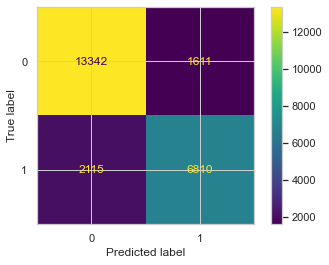

In [55]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
confusion_matrix_smote = confusion_matrix(test_new_y, smote_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_smote, display_labels = RF.classes_)
title = 'Confusion Matrix for SMOTE'
print(title)
disp.plot()

In [58]:
precision = confusion_matrix_smote[1][1]/(confusion_matrix_smote[1][1]+confusion_matrix_smote[0][1])
print('precision for SMOTE:' , precision)

precision for SMOTE: 0.8086925543284645


Confusion Matrix Without SMOTE


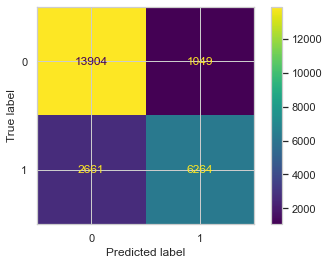

In [59]:
confusion_matrix_org = confusion_matrix(test_new_y, RFNEW_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_org, display_labels = RF.classes_)
title = 'Confusion Matrix Without SMOTE'
print(title)
disp.plot()

In [60]:
precision2 = confusion_matrix_org[1][1]/(confusion_matrix_org[1][1]+confusion_matrix_org[0][1])
print('precision for original:' , precision2)

precision for original: 0.8565568166279228


From the output, we can find that Random Forest trained with SMOTH dataset has better performance.

In [60]:
f = open('prediction.csv', 'w')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(smote_pred_test)

# close the file
f.close()